# Определение стоимости автомобилей

## Подготовка данных

### Загрузка данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/datasets/autos.csv')

### Просмотр и предобработка данных

In [ ]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


**Признаки**
*	DateCrawled — дата скачивания анкеты из базы
*	VehicleType — тип автомобильного кузова
*	RegistrationYear — год регистрации автомобиля
*	Gearbox — тип коробки передач
*	Power — мощность (л. с.)
*	Model — модель автомобиля
*	Kilometer — пробег (км)
*	RegistrationMonth — месяц регистрации автомобиля
*	FuelType — тип топлива
*	Brand — марка автомобиля
*	NotRepaired — была машина в ремонте или нет
*	DateCreated — дата создания анкеты
*	NumberOfPictures — количество фотографий автомобиля
*	PostalCode — почтовый индекс владельца анкеты (пользователя)
*	LastSeen — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Процент пропущенных данных

In [ ]:
data.isna().mean().sort_values(ascending=False).head(5)*100

NotRepaired    20.079070
VehicleType    10.579368
FuelType        9.282697
Gearbox         5.596709
Model           5.560588
dtype: float64

- NotRepaired - был ли ремонт. Можем предположить, что отсутствие информации о ремонте означает отсутствие ремонта, и поставить всем nan отрицательную метку (то есть 'yes').
- VehicleType - тип кузова. Тип кузова можем попробовать восстановить по названию модели.
- FuelType - тип топлива.
- Gearbox - тип коробки передач. Тип коробки передач и тип топлива мы можем попытаться восстановить по другим данным.
- Model - модель автомобиля. Восстановить название модели врядли получится, поэтому создадим пока что группу неопознанных автомобилей. Возможно, потом удалим (5% данных).

#### Проверка на дубликаты

In [ ]:
data.duplicated().sum()

4

In [ ]:
data[data.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


У нас есть 4 повторяющихся объекта. Удалим.

In [ ]:
print('Размер данных до удаления дубликатов:', len(data))
data = data.drop_duplicates().reset_index(drop=True)
print('Размер данных после удаления дубликатов:', len(data))

Размер данных до удаления дубликатов: 354369
Размер данных после удаления дубликатов: 354365


#### Данные datetime

В датасете есть пять признаков, содержащих даты, в том или ином виде:
- DateCrawled — дата скачивания анкеты из базы
- RegistrationYear — год регистрации автомобиля
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- LastSeen — дата последней активности пользователя

In [ ]:
data_date = data[['DateCrawled', 'RegistrationYear', 'RegistrationMonth', 'DateCreated', 'LastSeen']]
data_date.head(10)

,DateCrawled,RegistrationYear,RegistrationMonth,DateCreated,LastSeen
0,2016-03-24 11:52:17,1993,0,2016-03-24 00:00:00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,2011,5,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,2004,8,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,2001,6,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,2008,7,2016-03-31 00:00:00,2016-04-06 10:17:21
5,2016-04-04 17:36:23,1995,10,2016-04-04 00:00:00,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2004,8,2016-04-01 00:00:00,2016-04-05 18:18:39
7,2016-03-21 18:54:38,1980,7,2016-03-21 00:00:00,2016-03-25 16:47:58
8,2016-04-04 23:42:13,2014,8,2016-04-04 00:00:00,2016-04-04 23:42:13
9,2016-03-17 10:53:50,1998,0,2016-03-17 00:00:00,2016-03-31 17:17:06


Сами по себе эти данные модели не нужны, но из них можно получить еще пару признаков: 1) срок владения авто, 2) как долго объявление висит на сайте (полагаем, что чем дольше висит, тем сильнее дешевеет автомобиль по сравнению со свежевывешенным). 

In [ ]:
data_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 5 columns):
DateCrawled          354365 non-null object
RegistrationYear     354365 non-null int64
RegistrationMonth    354365 non-null int64
DateCreated          354365 non-null object
LastSeen             354365 non-null object
dtypes: int64(2), object(3)
memory usage: 13.5+ MB


##### Дата создания анкеты

In [ ]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'])

In [ ]:
data['DateCreated'].describe()

Все анкеты соданы с 2014 по 2016 год, никаких доисторических дат.

##### Дата скачивания анкеты

In [ ]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])

In [ ]:
data['DateCrawled'].describe()

count                  354365
unique                 271174
top       2016-03-24 14:49:47
freq                        7
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: DateCrawled, dtype: object

База скачана в марте-апреле 2016 года.

##### Месяц регистрации

In [ ]:
data['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

Мы видим нулевой месяц и 12 остальных. Полагаем, что в данной ситуации нулевой месяц - неуказанный месяц. Приравняем его к первому месяцу.

In [ ]:
data.loc[data['RegistrationMonth']==0, 'RegistrationMonth'] = 1 

##### Год регистрации

In [ ]:
def distributions(data, feature):
    data.boxplot(feature)
    plt.title(feature)
    plt.show()
    data[feature].hist()
    plt.title(feature)
    plt.show()

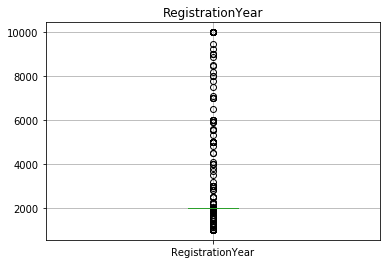

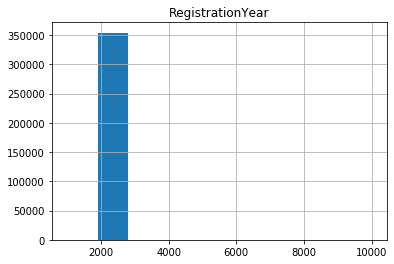

In [ ]:
distributions(data, 'RegistrationYear')

In [ ]:
data['RegistrationYear'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

В данных по году регистрации много выбросов, от которых придется избавится. Если мы будем делать это при помощи ящика с усами(даже если возьмём не 1.5-й, а 3-й межквартильный размах), данные будут отфильтрованы неверно. Нижняя граница окажется похожей на правду (73 год), а верхняя - 2019 - будет превышать самую последнюю дату создания анкеты ('DateCreated') - 2016-04-07. По этой причине попробуем установить границы реальных вариантов.

(*Изначальная версия, от которой отказались: Нижнюю границу предлагаем взять - 1975 год, потому что в этом году был введен очередной общий стандарт регистрации автомобилей в СССР. Основание:
«ПРАВИЛА РЕГИСТРАЦИИ И УЧЕТА АВТОМОТО ТРАНСПОРТНЫХ СРЕДСТВ В СССР». Приказ №20 МВД СССР. Дата введения 1975-01-30. То есть все данные ранее этой даты будем считать некорректными. Вероятно в базе могут быть ретроавтомобили, произведенные и раньше 1975 года, однако, они единичны, и выделить их из массы некорректных данных было бы непросто.*)

И тут мы узнали, что речь, вероятнее всего, идёт о Германии (по почтовым индексам). В таком случае будем отталкиваться от границы по тройному межквартильному размаху.

Верхняя граница - год скачивания анкеты из базы. 

Затем отсечём некорректные даты

In [ ]:
before = len(data)
r_threshold = data['DateCreated'].dt.year #собственно, 2016-й год
#l_threshold = 1975
l_threshold = data['RegistrationYear'].quantile(0.25) - (data['RegistrationYear'].quantile(0.75) - data['RegistrationYear'].quantile(0.25))*3
data = data[(data['RegistrationYear'] >= l_threshold) & (data['RegistrationYear'] <= r_threshold)]
loss = (1 - len(data)/before)*100
print('Процент потерянных данных:', loss)

Процент потерянных данных: 4.618966320037254


Теперь, когда у нас нет странных дат за пределами летоисчисления, можно создать столбец с датой регистрации авто. 

In [ ]:
data[['RegistrationYear', 'RegistrationMonth']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337997 entries, 0 to 354364
Data columns (total 2 columns):
RegistrationYear     337997 non-null int64
RegistrationMonth    337997 non-null int64
dtypes: int64(2)
memory usage: 7.7 MB


In [ ]:
data['RegistrationDate'] = pd.to_datetime(data['RegistrationYear'].astype(str)  + '-' + data['RegistrationMonth'].astype(str), format='%Y-%m')

И отфильтруем ещё раз с большей точностью

In [ ]:
before = len(data)
r_threshold = data['DateCreated']
l_threshold = pd.Timestamp(year=1975, month=1, day=30)
data = data[(
    data['RegistrationDate'] >= l_threshold) & (
    data['RegistrationDate'] <= r_threshold)]
loss = (1 - len(data)/before)*100
print('Процент потерянных данных от оставшихся:', loss)

Процент потерянных данных от оставшихся: 1.722796356180678


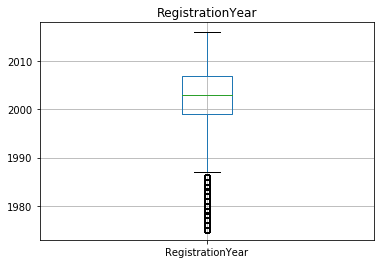

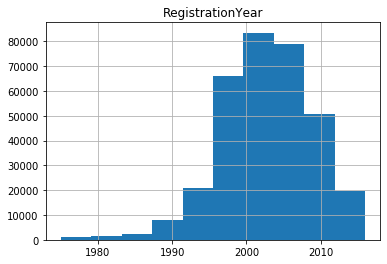

In [ ]:
distributions(data, 'RegistrationYear')

In [ ]:
data['RegistrationYear'].describe()

count    332174.000000
mean       2002.543549
std           6.052353
min        1975.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

Теперь данные года регистрации выглядят корректно.

##### Срок владения автомобилем после последней постановки на учёт

Вычислив разницу между датами регистрации автомобиля и создания анкеты для продажи (DateCreated), получим примерную информацию о том, как давно автомобиль у владельца.

In [ ]:
data['OwnershipPeriod'] = ((data['DateCreated'] - data['RegistrationDate']).dt.days)/365

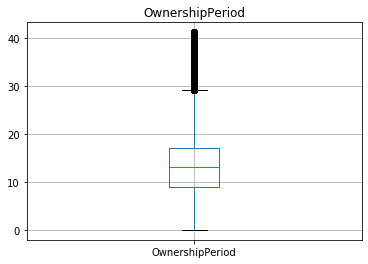

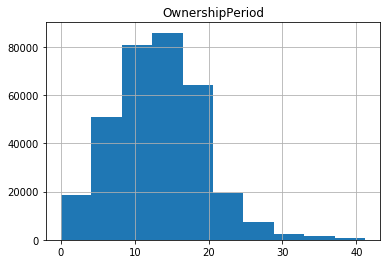

In [ ]:
distributions(data, 'OwnershipPeriod')

Распределение автомобильных возрастов выглядит вполне правдоподобно. Большинству 5-20 лет.

##### Возраст объявления.

Вычислим возраст объявления, исходя из того, когда владелец в последний раз имел возможность изменить цену. Здесь имеем следующее препятствие: у нас есть два столбца - скачивание анкеты и последнее посещение владельца. Так вот во многих случаях последнее посещение сайта владельцем случилось после скачивания анкеты. Значит ли это, что данные в анкете были обновлены, не ясно. Есть два пути: 1) вычислить разницу между датой создания объявления и датой последнего посещения в надежде, что данные о цене так же были обновлены, 2) вычислить разницу между датой создания объявления и датой последнего посещения, ограниченного датой скачивания (предполагаем, что объявление, не посещаемое владельцем неактуально - например, авто продано, но объявление снять забыли).

In [ ]:
data['LastSeen'] = pd.to_datetime(data['LastSeen'])

In [ ]:
data['AdAgeDays'] = ((data['LastSeen'] - data['DateCreated']).dt.days)

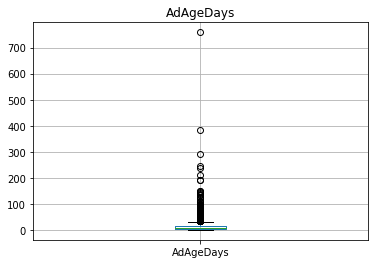

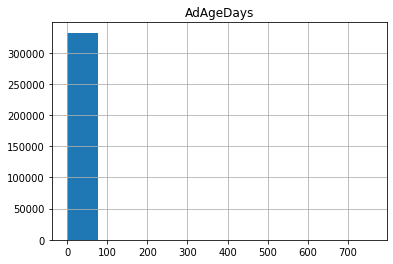

In [ ]:
distributions(data, 'AdAgeDays')

In [ ]:
data['AdAgeDays'].describe()

count    332174.000000
mean          8.748042
std           8.680338
min           0.000000
25%           2.000000
50%           6.000000
75%          14.000000
max         759.000000
Name: AdAgeDays, dtype: float64

В основном у нас 6-дневные объявления, но имеется и двухлетнее. 

#### Основные данные

In [ ]:
data_to_fit = data[['Price', 'VehicleType', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'NotRepaired', 'NumberOfPictures', 'PostalCode', 'OwnershipPeriod', 'AdAgeDays']]
data_to_fit.isna().mean().sort_values(ascending=False).head(5)*100

NotRepaired    18.592063
FuelType        7.393715
VehicleType     5.220457
Gearbox         5.065116
Model           4.904056
dtype: float64

- NotRepaired - был ли ремонт. Можем предположить, что отсутствие информации о ремонте означает отсутствие ремонта, и поставить всем nan отрицательную метку (то есть 'yes').
- VehicleType - тип кузова. Тип кузова можем попробовать восстановить по названию модели.
- FuelType - тип топлива.
- Gearbox - тип коробки передач. Тип коробки передач и тип топлива мы можем попытаться восстановить по другим данным.
- Model - модель автомобиля. Восстановить название модели врядли получится, поэтому создадим пока что группу неопознанных автомобилей. Возможно, потом удалим (5% данных).

##### Price

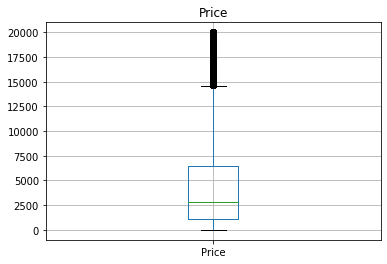

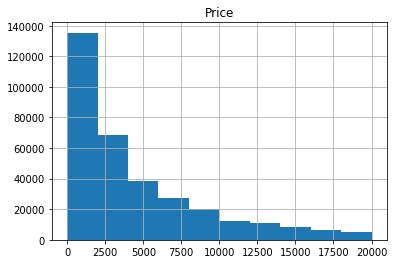

In [ ]:
distributions(data, 'Price')

In [ ]:
data['Price'].describe()

count    332174.000000
mean       4487.446498
std        4542.123139
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

Видим, что в базе имеются бесплатные автомобили. 

In [ ]:
(len(data[data['Price'] == 0])/len(data))*100

2.866268883175685

Почти три процента. Удалим.

In [ ]:
data = data[data['Price'] > 0]

##### Model

Пропущенные данные в столбце модели заменим на 'no_model'.

In [ ]:
data['Model'] = data['Model'].fillna('no_model')

##### NotRepaired

Предполагаем, что отсутствие информации о ремонте означает отсутствие ремонта, и поставим всем nan 'yes'.

In [ ]:
data['NotRepaired'] = data['NotRepaired'].fillna('yes')

In [ ]:
data['NotRepaired'].value_counts()

no     233328
yes     89325
Name: NotRepaired, dtype: int64

##### VehicleType

In [ ]:
data['VehicleType'].value_counts()

sedan          88683
small          77789
wagon          63634
bus            28271
convertible    19610
coupe          15279
suv            11678
other           2972
Name: VehicleType, dtype: int64

Заменим пропущенные значения в данных типа кузова на самые популярные в каждом типе модели авто.

In [ ]:
pivot = data.pivot_table(index='VehicleType', columns=['Brand', 'Model'], values='Price', aggfunc='count')
pivot.idxmax().reset_index().rename(columns={0:'VehicleType'})

,Brand,Model,VehicleType
0,alfa_romeo,145,small
1,alfa_romeo,147,sedan
2,alfa_romeo,156,wagon
3,alfa_romeo,159,wagon
4,alfa_romeo,no_model,sedan
...,...,...,...
332,volvo,v40,wagon
333,volvo,v50,wagon
334,volvo,v60,wagon
335,volvo,v70,wagon


In [ ]:
data['VehicleType'].value_counts()

sedan          88683
small          77789
wagon          63634
bus            28271
convertible    19610
coupe          15279
suv            11678
other           2972
Name: VehicleType, dtype: int64

In [ ]:
data['VehicleType'] = data['VehicleType'].fillna('what_is_this')
def fillna_feature(row, feature, pivot, replaceable):
    brand = row['Brand']
    model = row['Model']
    if row[feature] == replaceable:
        row[feature] = row[feature].replace(replaceable, pivot[brand][model].idxmax())
    return row[feature]
data['VehicleType'] = data.apply(fillna_feature, args=['VehicleType', pivot, 'what_is_this'], axis=1)

In [ ]:
data['VehicleType'].value_counts()

sedan          94405
small          82932
wagon          64964
bus            29621
convertible    19745
coupe          15608
suv            12398
other           2980
Name: VehicleType, dtype: int64

In [ ]:
data['VehicleType'].isna().sum()

0

##### FuelType

Тем же способом заменим пропуски в FuelType

In [ ]:
data['FuelType'].isna().sum()

21741

In [ ]:
data['FuelType'].value_counts()

petrol      200900
gasoline     94080
lpg           4970
cng            521
hybrid         215
other          140
electric        86
Name: FuelType, dtype: int64

In [ ]:
pivot = data.pivot_table(index='FuelType', columns=['Brand', 'Model'], values='Price', aggfunc='count')
pivot.idxmax().reset_index().rename(columns={0:'FuelType'}).sample(10)

,Brand,Model,FuelType
222,opel,zafira,petrol
39,chevrolet,other,petrol
113,hyundai,tucson,petrol
50,citroen,c2,petrol
121,jeep,other,gasoline
328,volvo,c_reihe,petrol
110,hyundai,no_model,petrol
82,fiat,other,petrol
33,bmw,x_reihe,gasoline
85,fiat,seicento,petrol


In [ ]:
data['FuelType'] = data['FuelType'].fillna('what_is_this')
data['FuelType'] = data.apply(fillna_feature, args=['FuelType', pivot, 'what_is_this'], axis=1)
#data['FuelType'] = data.apply(fillna_feature, args=['FuelType', pivot, 'other'], axis=1)

In [ ]:
data['FuelType'].value_counts()

petrol      219361
gasoline     97360
lpg           4970
cng            521
hybrid         215
other          140
electric        86
Name: FuelType, dtype: int64

##### Gearbox

In [ ]:
data['Gearbox'].value_counts()

manual    245891
auto       62080
Name: Gearbox, dtype: int64

In [ ]:
pivot = data.pivot_table(index='Gearbox', columns=['Brand', 'Model'], values='Price', aggfunc='count')
pivot.idxmax().reset_index().rename(columns={0:'Gearbox'}).sample(10)

,Brand,Model,Gearbox
310,volkswagen,fox,manual
290,suzuki,other,manual
157,mazda,5_reihe,manual
60,dacia,other,manual
127,kia,picanto,manual
178,mercedes_benz,slk,auto
112,hyundai,santa,manual
285,subaru,no_model,manual
249,rover,no_model,manual
195,mitsubishi,pajero,manual


Заполним пропуски.

In [ ]:
data['Gearbox'] = data['Gearbox'].fillna('what_is_this')
data['Gearbox'] = data.apply(fillna_feature, args=['Gearbox', pivot, 'what_is_this'], axis=1)

In [ ]:
data['Gearbox'].value_counts()

manual    258746
auto       63907
Name: Gearbox, dtype: int64

In [ ]:
data.isna().mean().sort_values(ascending=False).head(5)*100

NotRepaired    18.592063
FuelType        7.393715
VehicleType     5.220457
Gearbox         5.065116
Model           4.904056
dtype: float64

##### Kilometer

In [ ]:
data['Kilometer'].value_counts()

150000    216182
125000     33848
100000     13558
90000      10809
80000       9403
70000       8078
60000       7044
50000       5845
40000       4663
5000        4532
30000       4112
20000       3571
10000       1008
Name: Kilometer, dtype: int64

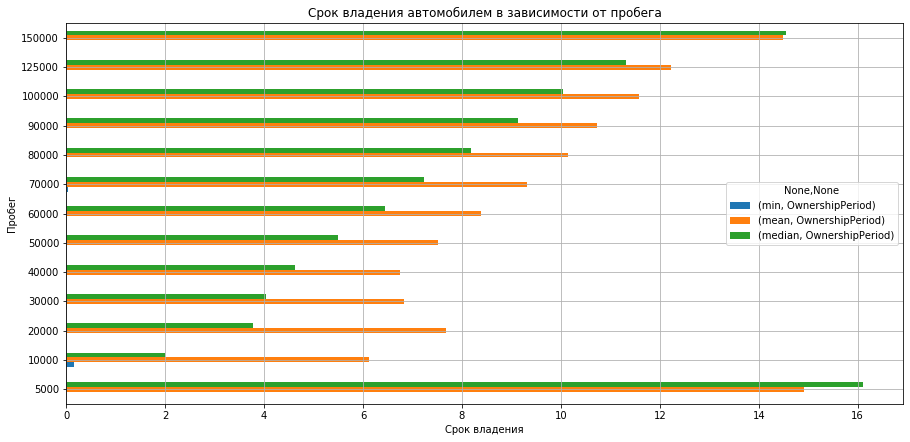

In [ ]:
data.pivot_table(index='Kilometer', values='OwnershipPeriod', aggfunc=['min', 'mean', 'median']).plot(kind='barh', grid=True, figsize=(15,7))
plt.title('Срок владения автомобилем в зависимости от пробега')
plt.xlabel('Срок владения')
plt.ylabel('Пробег')
plt.show()

In [ ]:
print('Количество вероятных перекупщиков:', len(data[(data['Kilometer'] >= 20000)&(data['OwnershipPeriod']==0)]))

Количество вероятных перекупщиков: 26


Неадекватных цифр пробега нет. Есть автомобили, которые продают не первые владельцы, но с точностью их не определить.

##### Power

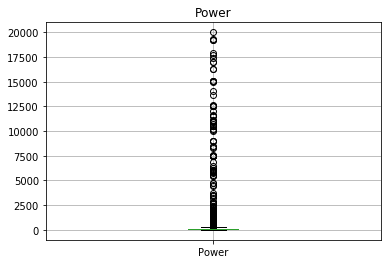

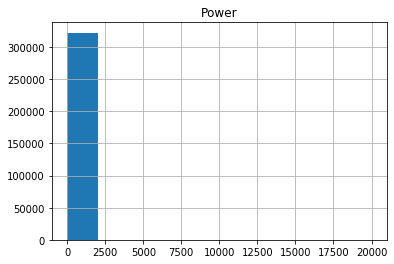

In [ ]:
distributions(data, 'Power')

In [ ]:
data['Power'].describe()

count    322653.000000
mean        112.569671
std         181.591874
min           0.000000
25%          73.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [ ]:
data[data['Power']==20000]['Brand']

219583    mercedes_benz
Name: Brand, dtype: object

Гугл говорит, что максимальная мощность Mercedes-Benz 2016 года - 630л.с.

In [ ]:
print('Автомобили, мощность двигателей который указана как нулевая:', len(data[data['Power']==0]))

Автомобили, мощность двигателей который указана как нулевая: 30952


Так как в списке нет ни Bugatti, ни Ferrari, ограничим мощность двигателей.

Верхняя граница - 630 лошадиных сил.
Нижняя граница - 15 лошадиных сил.
Ориентируемся на авто на сайтах вроде авто.ру.
Некоректные данные заменим, исходя из бренда, модели и типа двигателя.

In [ ]:
correct_power_data = data[(data['Power']<=630)&(data['Power']>=12)]

In [ ]:
(1 - len(correct_power_data)/len(data))*100

9.758161244432873

Некорректных данных в столбце можности почти 10%

In [ ]:
pivot = correct_power_data.pivot_table(index='Power', columns=['Brand', 'Model'], values='Price', aggfunc='count')
type_power = pivot.idxmax().reset_index().rename(columns={0:'Power'})
pivot.index = pivot.index.astype(object)

In [ ]:
data['Power'].describe()

count    322653.000000
mean        112.569671
std         181.591874
min           0.000000
25%          73.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [ ]:
median_power = str(data['Power'].median())
data.loc[data['Power'] >= 630, 'Power'] = 0
data.loc[data['Power'] <= 15, 'Power'] = 'what_is_power'

In [ ]:
data['Power'].value_counts().head()

what_is_power    31522
75               21618
60               14392
150              13595
140              12201
Name: Power, dtype: int64

Заместим 'what_is_power' медианным значением можности, так как для привычного заполнения по сводной таблице у нас не хватает данных.

In [ ]:
data.loc[data['Power'] == 'what_is_power', 'Power'] = median_power

In [ ]:
data['Power'] = data['Power'].astype(float)

In [ ]:
data['Power'] = data['Power'].astype(int)

In [ ]:
data['Power'].describe()

count    322653.000000
mean        119.489907
std          51.340835
min          16.000000
25%          84.000000
50%         105.000000
75%         143.000000
max         620.000000
Name: Power, dtype: float64

##### NumberOfPictures

In [ ]:
data['NumberOfPictures'].value_counts()

0    322653
Name: NumberOfPictures, dtype: int64

Информации о количестве фотографий в объявлениях у нас нет. Удалим пустой столбец.

In [ ]:
del data['NumberOfPictures']

##### PostalCode

In [ ]:
data['PostalCode'].value_counts()

10115    808
65428    557
66333    302
32257    283
44145    282
        ... 
83379      1
89368      1
72655      1
17154      1
29361      1
Name: PostalCode, Length: 8129, dtype: int64

In [ ]:
data['PostalCode'].describe()

count    322653.000000
mean      50829.046366
std       25761.766857
min        1067.000000
25%       30519.000000
50%       49661.000000
75%       71384.000000
max       99998.000000
Name: PostalCode, dtype: float64

У нас 8129 почтовых индексов, которые могут сообщать о регионе продажи автомобиля. Регион может влиять на цену. Пока оставим признак.

Text(0, 0.5, 'Количество почтовых индексов')

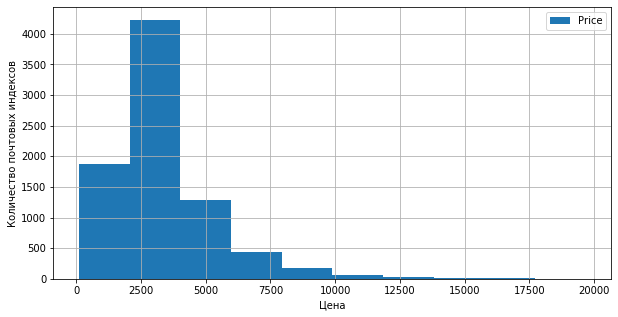

In [ ]:
data.pivot_table(index='PostalCode', values='Price', aggfunc='median').plot(
    kind='hist', grid=True, figsize=(10,5))
plt.xlabel('Цена')
plt.ylabel('Количество почтовых индексов')

In [ ]:
data[data['Price']==data['Price'].max()]['PostalCode'].value_counts().head(3)

10115    24
60311     8
12685     3
Name: PostalCode, dtype: int64

In [ ]:
data[data['Price']==data['Price'].min()]['PostalCode'].value_counts().head(3)

59269    8
57614    7
33330    6
Name: PostalCode, dtype: int64

In [ ]:
data['PostalCode'].value_counts().sample(20)

86833     24
56727     85
24622      6
32052    111
82335     19
60313     54
97993     11
82293      7
74936      6
61479     32
38644     34
70329     48
46147    130
67550     42
30900    150
63925     10
72414     23
34399     13
74532     19
36320     15
Name: PostalCode, dtype: int64

24 самых дорогих автомобиля в датасете продается собственниками, за которыми закреплен почтовый индекс 10115, и если индексы реальные, то автомобили в Берлине. 8 самых дешевых - в Беккум (тоже Германия). Проверив случайный набор индексов, можем предположить, что речь о продажах в Германии.
Беда в том, что признак категориальный. И категорий 8129. Попробуем сократить их количество. Гугл говорит, что первая цифра индекса в Германии обозначает почтовую зону (их всего 10 - от 0 до 9). Две первых цифры индекса обозначают почтовый регион. Предполагаем, что для разных регионов цена и востребованность автомобиля может отличаться (например, врядли будет куплен старенький автомобиль там, куда не пускают авто ниже очередного евро стандарта).

In [ ]:
def postal_region(row):
    n = 9999
    m = 10000
    if row <=n:
        return 0
    if row <= n+m:
        return 1
    if row <= n+2*m:
        return 2
    if row <= n+3*m:
        return 3
    if row <= n+4*m:
        return 4
    if row <= n+5*m:
        return 5
    if row <= n+6*m:
        return 6
    if row <= n+7*m:
        return 7
    if row <= n+8*m:
        return 8
    if row <= n+9*m:
        return 9
    else:
        return 'unidentified'

In [ ]:
data['Region'] = data['PostalCode'].apply(postal_region)

In [ ]:
data['Region'].value_counts()

4    44406
5    42695
3    39280
2    38403
6    32523
8    29879
7    29304
9    25508
1    24668
0    15987
Name: Region, dtype: int64

In [ ]:
data['Region'] = data['Region'].astype(str)

### Подготовка признаков

In [ ]:
data.isna().mean()

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
DateCreated          0.0
PostalCode           0.0
LastSeen             0.0
RegistrationDate     0.0
OwnershipPeriod      0.0
AdAgeDays            0.0
Region               0.0
dtype: float64

Определим список признаков, которые отправим в модель.

In [ ]:
data_to_fit = data[['Price', 'VehicleType', 'Gearbox', 'Power', 'Model', 'Kilometer',
       'FuelType', 'Brand', 'NotRepaired', 'Region',
       'OwnershipPeriod', 'AdAgeDays']]

In [ ]:
data_to_fit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322653 entries, 0 to 354364
Data columns (total 12 columns):
Price              322653 non-null int64
VehicleType        322653 non-null object
Gearbox            322653 non-null object
Power              322653 non-null int64
Model              322653 non-null object
Kilometer          322653 non-null int64
FuelType           322653 non-null object
Brand              322653 non-null object
NotRepaired        322653 non-null object
Region             322653 non-null object
OwnershipPeriod    322653 non-null float64
AdAgeDays          322653 non-null int64
dtypes: float64(1), int64(4), object(7)
memory usage: 32.0+ MB


In [ ]:
cat_features = []
for feature in data_to_fit.columns:
    if data_to_fit[feature].dtype == 'object':
        cat_features.append(feature)
cat_features

['VehicleType',
 'Gearbox',
 'Model',
 'FuelType',
 'Brand',
 'NotRepaired',
 'Region']

#### Прямое кодирование

Данные типа object будут закодированы.

In [ ]:
data_to_fit_ohe = pd.get_dummies(data_to_fit, drop_first=True)

In [ ]:
data_to_fit_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322653 entries, 0 to 354364
Columns: 318 entries, Price to Region_9
dtypes: float64(1), int64(4), uint8(313)
memory usage: 111.1 MB


In [ ]:
data_to_fit_ohe.head()

,Price,Power,Kilometer,OwnershipPeriod,AdAgeDays,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,NotRepaired_yes,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9
0,480,105,150000,23.241096,14,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
1,18300,190,125000,4.901370,14,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,9800,163,125000,11.624658,22,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,1500,75,150000,14.802740,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,3600,69,90000,7.753425,6,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


#### Порядковое кодирование

Для LGBMRegressor понядобятся порядковым образом закодированные категории.

In [ ]:
data_to_fit_label = data_to_fit
encoder = LabelEncoder()

for feature in cat_features:
    data_to_fit_label[feature] = encoder.fit_transform(data_to_fit_label[feature])

In [ ]:
data_to_fit_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322653 entries, 0 to 354364
Data columns (total 12 columns):
Price              322653 non-null int64
VehicleType        322653 non-null int64
Gearbox            322653 non-null int64
Power              322653 non-null int64
Model              322653 non-null int64
Kilometer          322653 non-null int64
FuelType           322653 non-null int64
Brand              322653 non-null int64
NotRepaired        322653 non-null int64
Region             322653 non-null int64
OwnershipPeriod    322653 non-null float64
AdAgeDays          322653 non-null int64
dtypes: float64(1), int64(11)
memory usage: 32.0 MB


In [ ]:
data_to_fit_label

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,Region,OwnershipPeriod,AdAgeDays
0,480,4,1,105,116,150000,6,38,1,7,23.241096,14
1,18300,2,1,190,161,125000,2,1,1,6,4.901370,14
2,9800,6,0,163,117,125000,2,14,1,9,11.624658,22
3,1500,5,1,75,116,150000,6,38,0,9,14.802740,0
4,3600,5,1,69,101,90000,2,31,0,6,7.753425,6
...,...,...,...,...,...,...,...,...,...,...,...,...
354359,1150,0,1,105,250,150000,6,24,0,2,16.082192,2
354361,2200,6,1,105,161,20000,6,33,1,3,11.205479,23
354362,1199,1,0,101,106,125000,6,32,0,2,16.021918,6
354363,9200,0,1,102,225,150000,2,38,0,8,20.063014,19


#### Таргет и признаки

In [ ]:
target = data_to_fit['Price']
features = data_to_fit.drop('Price', axis=1)

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

##### ohe

In [ ]:
target_ohe = data_to_fit_ohe['Price']
features_ohe = data_to_fit_ohe.drop('Price', axis=1)

In [ ]:
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=12345)

##### label

In [ ]:
target_label = data_to_fit_label['Price']
features_label = data_to_fit_label.drop('Price', axis=1)

In [ ]:
features_train_label, features_test_label, target_train_label, target_test_label = train_test_split(
    features_label, target_label, test_size=0.25, random_state=12345)

#### Масштабирование признаков

##### ohe

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train_ohe) 
features_train_ohe = scaler.transform(features_train_ohe)
features_test_ohe = scaler.transform(features_test_ohe)

##### label

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train_label) 
features_train_label = scaler.transform(features_train_label)
features_test_label = scaler.transform(features_test_label)

## Обучение моделей

### LinearRegression

In [ ]:
%%time

model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)

CPU times: user 24.1 s, sys: 7.85 s, total: 31.9 s
Wall time: 32.1 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
%%time

predict_lr_train = model.predict(features_train_ohe)

CPU times: user 253 ms, sys: 28.3 ms, total: 281 ms
Wall time: 280 ms


In [ ]:
rmse_lr_train = mean_squared_error(target_train_ohe, predict_lr_train) ** 0.5

In [ ]:
%%time

predict_lr_test = model.predict(features_test_ohe)

CPU times: user 72.2 ms, sys: 826 µs, total: 73 ms
Wall time: 29.7 ms


In [ ]:
rmse_lr_test = mean_squared_error(target_test_ohe, predict_lr_test) ** 0.5

In [ ]:
print('rmse_lr_train =', rmse_lr_train)
print('rmse_lr_test =', rmse_lr_test)

rmse_lr_train = 2519.8332990011068
rmse_lr_test = 120656000982.74846


### Lasso

In [ ]:
%%time

model = Lasso()
model.fit(features_train_ohe, target_train_ohe)

CPU times: user 4min 20s, sys: 1min 36s, total: 5min 57s
Wall time: 5min 58s


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
%%time

predict_lasso_train = model.predict(features_train_ohe)

CPU times: user 220 ms, sys: 30.4 ms, total: 250 ms
Wall time: 293 ms


In [ ]:
rmse_lasso_train = mean_squared_error(target_train_ohe, predict_lasso_train) ** 0.5

In [ ]:
%%time

predict_lasso_test = model.predict(features_test_ohe)

CPU times: user 82.1 ms, sys: 18.2 ms, total: 100 ms
Wall time: 104 ms


In [ ]:
rmse_lasso_test = mean_squared_error(target_test_ohe, predict_lasso_test) ** 0.5

In [ ]:
print('rmse_lasso_train =', rmse_lasso_train)
print('rmse_lasso_test =', rmse_lasso_test)

rmse_lasso_train = 2520.265912947763
rmse_lasso_test = 2510.0922746211354


### RandomForestRegressor

К сожалению, одновременный подбор гиперпараметров приводил к kernel dead, поэтому здесь и далее подбирать значения гиперпараметров будем по одному.

In [ ]:
%%time

forest = RandomForestRegressor()
forest_params = {'max_depth': [5,9,13,17]}
forest_grid = GridSearchCV(forest, param_grid=forest_params, cv=3, scoring='neg_mean_squared_error')
forest_grid.fit(features_train_ohe, target_train_ohe)

parametr = {
    'parametr': forest_grid.cv_results_['params'],
    'rmse': (forest_grid.cv_results_['mean_test_score'] * -1) ** 0.5
}
parametr = pd.DataFrame(parametr).sort_values(by='rmse', ascending=True).reset_index(drop=True)
best_parametr = parametr.loc[0, 'parametr']
print('best_depth:', best_parametr)
parametr

best_depth: {'max_depth': 17}
CPU times: user 10min 47s, sys: 0 ns, total: 10min 47s
Wall time: 10min 58s


,parametr,rmse
0,{'max_depth': 17},1685.966549
1,{'max_depth': 13},1764.353605
2,{'max_depth': 9},1961.219147
3,{'max_depth': 5},2376.259219


In [ ]:
best_depth = best_parametr['max_depth']

In [ ]:
%%time

forest = RandomForestRegressor()
forest_params = {'n_estimators': [100, 120, 140], 'max_depth': [best_depth]}
forest_grid = GridSearchCV(forest, param_grid=forest_params, cv=3, scoring='neg_mean_squared_error')
forest_grid.fit(features_train_ohe, target_train_ohe)
parametr = {
    'parametr': forest_grid.cv_results_['params'],
    'rmse': (forest_grid.cv_results_['mean_test_score'] * -1) ** 0.5
}
parametr = pd.DataFrame(parametr).sort_values(by='rmse', ascending=True).reset_index(drop=True)
best_parametr = parametr.loc[0, 'parametr']
print('best_params:', best_parametr)
parametr

best_params: {'max_depth': 17, 'n_estimators': 140}
CPU times: user 2h 51s, sys: 2.76 s, total: 2h 54s
Wall time: 2h 2min 29s


,parametr,rmse
0,"{'max_depth': 17, 'n_estimators': 140}",1642.439690
1,"{'max_depth': 17, 'n_estimators': 120}",1642.644698
2,"{'max_depth': 17, 'n_estimators': 100}",1644.808532


In [ ]:
best_est = best_parametr['n_estimators']

In [ ]:
%%time

forest = RandomForestRegressor()
forest_params = {'n_estimators': [best_est], 'max_depth': [best_depth]}
forest_grid = GridSearchCV(forest, param_grid=forest_params, cv=3, scoring='neg_mean_squared_error')
forest_grid.fit(features_train_ohe, target_train_ohe)
parametr = {
    'parametr': forest_grid.cv_results_['params'],
    'rmse': (forest_grid.cv_results_['mean_test_score'] * -1) ** 0.5
}
parametr = pd.DataFrame(parametr).sort_values(by='rmse', ascending=True).reset_index(drop=True)
best_parametr = parametr.loc[0, 'parametr']
print('best_params:', best_parametr)
parametr

best_params: {'max_depth': 17, 'n_estimators': 140}
CPU times: user 55min 20s, sys: 3.18 s, total: 55min 23s
Wall time: 56min 4s


,parametr,rmse
0,"{'max_depth': 17, 'n_estimators': 140}",1643.777961


In [ ]:
%%time

predict_forest_train = forest_grid.predict(features_train_ohe)

CPU times: user 10.4 s, sys: 108 ms, total: 10.5 s
Wall time: 10.5 s


In [ ]:
rmse_forest_train = mean_squared_error(target_train_ohe, predict_forest_train) ** 0.5

In [ ]:
%%time

predict_forest_test = forest_grid.predict(features_test_ohe)

CPU times: user 3.45 s, sys: 44.1 ms, total: 3.49 s
Wall time: 3.5 s


In [ ]:
rmse_forest_test = mean_squared_error(target_test_ohe, predict_forest_test) ** 0.5

In [ ]:
print('rmse_forest_train =', rmse_forest_train)
print('rmse_forest_test =', rmse_forest_test)

rmse_forest_train = 1170.9822757849013
rmse_forest_test = 1610.2857144697798


### CatBoostRegressor

CatBoost мы отправим незакодированные данные, потому что он и сам должен уметь с ними справляться, и это будет очевидным преимуществом (меньше подготовки).

In [ ]:
%%time

cat = CatBoostRegressor(loss_function='RMSE')
cat_params = {'depth': range(5,17,2), 'iterations': [30]}
cat_grid = cat.grid_search(cat_params,
            Pool(features_train, target_train, cat_features=cat_features),
            cv=3,
            verbose=True,
            plot=False)

0:	loss: 3478.9189619	best: 3478.9189619 (0)	total: 5.89s	remaining: 29.5s
1:	loss: 3396.3337120	best: 3396.3337120 (1)	total: 11s	remaining: 22s
2:	loss: 3342.0907645	best: 3342.0907645 (2)	total: 17.5s	remaining: 17.5s
3:	loss: 3309.3762737	best: 3309.3762737 (3)	total: 27s	remaining: 13.5s
4:	loss: 3294.4965262	best: 3294.4965262 (4)	total: 43.7s	remaining: 8.74s
5:	loss: 3301.4929528	best: 3294.4965262 (4)	total: 1m 22s	remaining: 0us
Estimating final quality...
CPU times: user 2min 14s, sys: 13.2 s, total: 2min 27s
Wall time: 2min 32s


In [ ]:
cat_grid['params']

{'depth': 13, 'iterations': 30}

In [ ]:
best_depth = cat_grid['params']['depth']

In [ ]:
%%time

cat = CatBoostRegressor(loss_function='RMSE')
cat_params = {'depth': [best_depth], 
                       'iterations': range(70,160,30)}
cat_grid = cat.grid_search(cat_params,
            Pool(features_train, target_train, cat_features=cat_features),
            cv=3,
            verbose=True,
            plot=False)

0:	loss: 2062.2946366	best: 2062.2946366 (0)	total: 41.2s	remaining: 1m 22s
1:	loss: 1830.2853092	best: 1830.2853092 (1)	total: 1m 37s	remaining: 48.8s
2:	loss: 1747.1204548	best: 1747.1204548 (2)	total: 2m 51s	remaining: 0us
Estimating final quality...
CPU times: user 6min 55s, sys: 40.5 s, total: 7min 36s
Wall time: 7min 43s


In [ ]:
cat_grid['params']

{'depth': 13, 'iterations': 130}

In [ ]:
best_iter = cat_grid['params']['iterations']

In [ ]:
%%time

cat = CatBoostRegressor(loss_function='RMSE')
cat_params = {'depth': [best_depth], 
                       'iterations': [best_iter], 
                       'learning_rate': np.arange(0.1, 1.0, 0.1)}
cat_grid = cat.grid_search(cat_params,
            Pool(features_train, target_train, cat_features=cat_features),
            cv=3,
            verbose=True,
            plot=False)

0:	loss: 1602.8883251	best: 1602.8883251 (0)	total: 1m 15s	remaining: 10m 4s
1:	loss: 1579.7245023	best: 1579.7245023 (1)	total: 2m 28s	remaining: 8m 41s
2:	loss: 1582.9184535	best: 1579.7245023 (1)	total: 3m 41s	remaining: 7m 23s
3:	loss: 1589.9088801	best: 1579.7245023 (1)	total: 4m 55s	remaining: 6m 8s
4:	loss: 1613.1139001	best: 1579.7245023 (1)	total: 6m 7s	remaining: 4m 53s
5:	loss: 1617.7531738	best: 1579.7245023 (1)	total: 7m 20s	remaining: 3m 40s
6:	loss: 1651.4628986	best: 1579.7245023 (1)	total: 8m 34s	remaining: 2m 26s
7:	loss: 1672.0328999	best: 1579.7245023 (1)	total: 9m 48s	remaining: 1m 13s
8:	loss: 1699.8564531	best: 1579.7245023 (1)	total: 11m 3s	remaining: 0us
Estimating final quality...
CPU times: user 14min 22s, sys: 1min 20s, total: 15min 42s
Wall time: 15min 54s


In [ ]:
cat_grid['params']

{'depth': 13, 'iterations': 130, 'learning_rate': 0.2}

In [ ]:
best_learning_rate = cat_grid['params']['learning_rate']

In [ ]:
best_params = cat_grid['params']

In [ ]:
%%time

cat = CatBoostRegressor(loss_function='RMSE')
cat_params = best_params
cat_grid = cat.grid_search({'depth': [best_depth], 
                       'iterations': [best_iter], 
                       'learning_rate': [best_learning_rate]},
            Pool(features_train, target_train, cat_features=cat_features),
            cv=3,
            verbose=True,
            plot=False)

0:	loss: 1579.7245023	best: 1579.7245023 (0)	total: 1m 15s	remaining: 0us
Estimating final quality...
CPU times: user 5min 27s, sys: 28.7 s, total: 5min 56s
Wall time: 6min 2s


In [ ]:
cat_grid['params']

{'depth': 13, 'iterations': 130, 'learning_rate': 0.2}

In [ ]:
%%time
predict_cat_test = cat.predict(features_test)
rmse_cat_test = mean_squared_error(target_test, predict_cat_test) ** 0.5

CPU times: user 120 ms, sys: 36.3 ms, total: 156 ms
Wall time: 130 ms


In [ ]:
print('rmse_cat_test =', rmse_cat_test)

rmse_cat_test = 1551.6051783456494


### LGBMRegressor

In [ ]:
%%time

lgbm = LGBMRegressor()
lgbm_params = {'max_depth': [5,9,13,17]}
lgbm_grid = GridSearchCV(lgbm, param_grid=lgbm_params, cv=3, scoring='neg_mean_squared_error')
lgbm_grid.fit(features_train_label, target_train_label)
parametr = {
    'parametr': lgbm_grid.cv_results_['params'],
    'rmse': (lgbm_grid.cv_results_['mean_test_score'] * -1) ** 0.5
}
parametr = pd.DataFrame(parametr).sort_values(by='rmse', ascending=True).reset_index(drop=True)
best_parametr = parametr.loc[0, 'parametr']
print('best_depth:', best_parametr)
parametr


best_depth: {'max_depth': 13}
CPU times: user 2min 9s, sys: 896 ms, total: 2min 9s
Wall time: 2min 12s


,parametr,rmse
0,{'max_depth': 13},1678.866074
1,{'max_depth': 17},1679.105502
2,{'max_depth': 9},1681.618529
3,{'max_depth': 5},1725.605821


In [ ]:
best_depth = best_parametr['max_depth']

In [ ]:
%%time

lgbm = LGBMRegressor()
lgbm_params = {'n_estimators': [100, 120, 140], 'max_depth': [best_depth]}
lgbm_grid = GridSearchCV(lgbm, param_grid=lgbm_params, cv=3, scoring='neg_mean_squared_error')
lgbm_grid.fit(features_train_label, target_train_label)
parametr = {
    'parametr': lgbm_grid.cv_results_['params'],
    'rmse': (lgbm_grid.cv_results_['mean_test_score'] * -1) ** 0.5
}
parametr = pd.DataFrame(parametr).sort_values(by='rmse', ascending=True).reset_index(drop=True)
best_parametr = parametr.loc[0, 'parametr']
print('best_params:', best_parametr)
parametr


best_params: {'max_depth': 13, 'n_estimators': 140}
CPU times: user 7min 36s, sys: 2.47 s, total: 7min 39s
Wall time: 7min 44s


,parametr,rmse
0,"{'max_depth': 13, 'n_estimators': 140}",1648.353292
1,"{'max_depth': 13, 'n_estimators': 120}",1662.063990
2,"{'max_depth': 13, 'n_estimators': 100}",1678.866074


In [ ]:
best_est = best_parametr['n_estimators']

In [ ]:
%%time

lgbm = LGBMRegressor()
lgbm_params = {'n_estimators': [best_est], 'max_depth': [best_depth], 'learning_rate': [0.1, 0.5, 1.0]}
lgbm_grid = GridSearchCV(lgbm, param_grid=lgbm_params, cv=3, scoring='neg_mean_squared_error')
lgbm_grid.fit(features_train_label, target_train_label)
parametr = {
    'parametr': lgbm_grid.cv_results_['params'],
    'rmse': (lgbm_grid.cv_results_['mean_test_score'] * -1) ** 0.5
}
parametr = pd.DataFrame(parametr).sort_values(by='rmse', ascending=True).reset_index(drop=True)
best_parametr = parametr.loc[0, 'parametr']
print('best_params:', best_parametr)
parametr

best_params: {'learning_rate': 0.5, 'max_depth': 13, 'n_estimators': 140}
CPU times: user 10min 31s, sys: 3.28 s, total: 10min 34s
Wall time: 10min 40s


,parametr,rmse
0,"{'learning_rate': 0.5, 'max_depth': 13, 'n_est...",1620.567714
1,"{'learning_rate': 0.1, 'max_depth': 13, 'n_est...",1648.353292
2,"{'learning_rate': 1.0, 'max_depth': 13, 'n_est...",1737.257956


In [ ]:
best_learning_rate = best_parametr['learning_rate']

In [ ]:
%%time

lgbm = LGBMRegressor()
lgbm_params = {'n_estimators': [best_est], 'max_depth': [best_depth], 'learning_rate': [best_learning_rate]}
lgbm_grid = GridSearchCV(lgbm, param_grid=lgbm_params, cv=3, scoring='neg_mean_squared_error')
lgbm_grid.fit(features_train_label, target_train_label)
parametr = {
    'parametr': lgbm_grid.cv_results_['params'],
    'rmse': (lgbm_grid.cv_results_['mean_test_score'] * -1) ** 0.5
}
parametr = pd.DataFrame(parametr).sort_values(by='rmse', ascending=True).reset_index(drop=True)
best_parametr = parametr.loc[0, 'parametr']
print('best_params:', best_parametr)
parametr

best_params: {'learning_rate': 0.5, 'max_depth': 13, 'n_estimators': 140}
CPU times: user 34.9 s, sys: 263 ms, total: 35.2 s
Wall time: 35.6 s


,parametr,rmse
0,"{'learning_rate': 0.5, 'max_depth': 13, 'n_est...",1620.567714


In [ ]:
predict_lgbm_train = lgbm_grid.predict(features_train_label)
rmse_lgbm_train = mean_squared_error(target_train_label, predict_lgbm_train) ** 0.5

In [ ]:
%%time
predict_lgbm_test = lgbm_grid.predict(features_test_label)
rmse_lgbm_test = mean_squared_error(target_test_label, predict_lgbm_test) ** 0.5

CPU times: user 868 ms, sys: 0 ns, total: 868 ms
Wall time: 881 ms


In [ ]:
print('rmse_lgbm_train =', rmse_lgbm_train)
print('rmse_lgbm_test =', rmse_lgbm_test)

rmse_lgbm_train = 1452.7166435574566
rmse_lgbm_test = 1587.3380978654568


## Анализ моделей

### Сравнение rmse

In [ ]:
rmse_of_models = {
    'models': ['rmse_lr', 'rmse_lasso', 'rmse_forest', 'rmse_lgbm', 'rmse_cat'],
    'rmse': [rmse_lr_test, rmse_lasso_test, rmse_forest_test, rmse_lgbm_test, rmse_cat_test]
}
rmse_of_models = pd.DataFrame(rmse_of_models).set_index('models')
rmse_of_models.sort_values(by='rmse', ascending=True)

Наименьшей среднеквадратичной ошибки  на тестовой выборке удалось достичь при помощи CatBoost. При более тщательном подборе гиперпараметров, вероятно, предсказание было бы ещё точнее.

### Сравнение времени обучения

In [ ]:
time_for_train = {
    'models': ['time_for_train_lr', 'time_for_train_lasso', 'time_for_train_forest', 'time_for_train_lgbm', 'time_for_train_cat'],
    'time': ['32.1 s', '5min 58s', '56min 4s', '35.6 s', '6min 2s']
}
time_for_train = pd.DataFrame(time_for_train).set_index('models')
time_for_train

,time
models,
time_for_train_lr,32.1 s
time_for_train_lasso,5min 58s
time_for_train_forest,56min 4s
time_for_train_lgbm,35.6 s
time_for_train_cat,6min 2s


По скорости обучения побеждают низкокачественные модели. Из давших более точное предсказание быстрее всех обучился LGBMRegressor.

### Сравнение скорости предсказания

In [ ]:
time_for_predict = {
    'models': ['time_for_predict_lr', 'time_for_predict_lasso', 'time_for_predict_forest', 'time_for_predict_lgbm', 'time_for_predict_cat'],
    'time': ['29.7 ms', '104 ms', '3.5 s', '881 ms', '130 ms']
}
time_for_predict = pd.DataFrame(time_for_predict).set_index('models')
time_for_predict

,time
models,
time_for_predict_lr,29.7 ms
time_for_predict_lasso,104 ms
time_for_predict_forest,3.5 s
time_for_predict_lgbm,881 ms
time_for_predict_cat,130 ms


Предсказание опять же самое быстрое у линейных моделей, но в сочетании с качеством предсказания по скорости выигрывает CatBoostRegressor.

## Вывод

- Мы подготовили данные: удалили некорректные, заполнили пропуски, присвоили категории.
- Обучили несколько моделей, среди которых две линейные, один ансамблевый набор и два бустинга. Замерили время обучения, предсказания и rmse моделей, так как мы помним, что заказчику важны: качество предсказания, скорость предсказания и время обучения.
- Сравнение показало, что лучший результат у градиентного бустинга CatBoostRegressor при минимально подготовленных данных. Хоть и учится он дольше мгновенной линейной регрессии. 
